<a href="https://colab.research.google.com/github/jwasswa2023/Physpropnet/blob/main/VIP_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-4147270144.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vip[i] = np.sqrt(p * (s.T @ weight) / total_s)
/tmp/ipython-input-4147270144.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=vip_grouped, x='VIP Score', y='Group', palette='viridis')


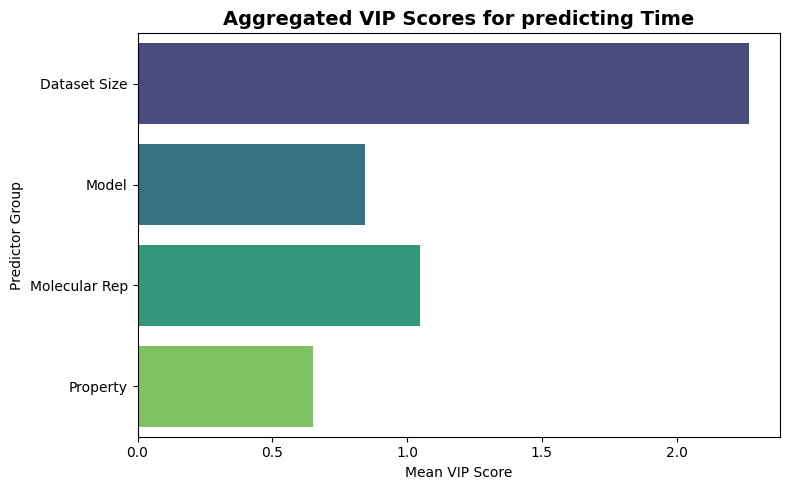

/tmp/ipython-input-4147270144.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vip[i] = np.sqrt(p * (s.T @ weight) / total_s)
/tmp/ipython-input-4147270144.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=vip_grouped, x='VIP Score', y='Group', palette='viridis')


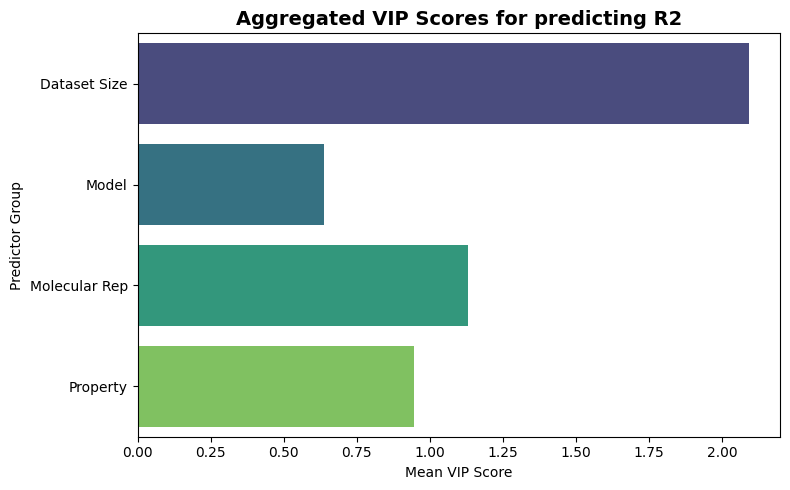

/tmp/ipython-input-4147270144.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vip[i] = np.sqrt(p * (s.T @ weight) / total_s)
/tmp/ipython-input-4147270144.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=vip_grouped, x='VIP Score', y='Group', palette='viridis')


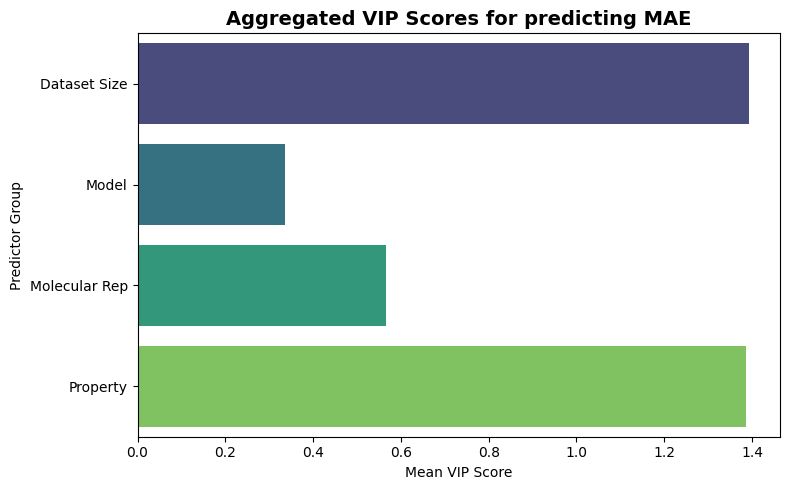

/tmp/ipython-input-4147270144.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vip[i] = np.sqrt(p * (s.T @ weight) / total_s)
/tmp/ipython-input-4147270144.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=vip_grouped, x='VIP Score', y='Group', palette='viridis')


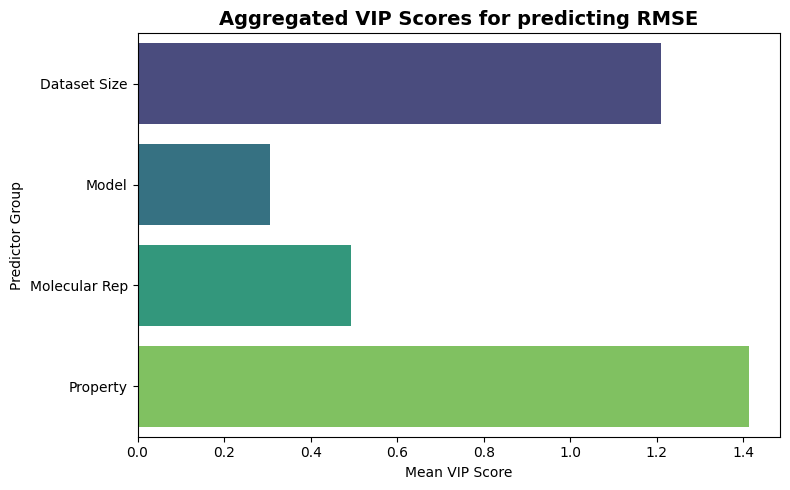


✅ VIP mean results saved to VIP_Mean_Results.csv


In [ ]:
# ===================== VIP PLOTS AGGREGATED BY PREDICTOR GROUP + SAVE MEAN RESULTS ===================== #

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cross_decomposition import PLSRegression
from sklearn.compose import ColumnTransformer

# Load dataset
df = pd.read_csv("SUMMARY.csv")

# Clean target columns: extract only the numeric mean if formatted as "mean ± std"
for target in ['Time', 'R2', 'MAE', 'RMSE']:
    df[target] = df[target].astype(str).str.extract(r'([-\d\.]+)').astype(float)

# Define predictors and targets
predictors = ['Property', 'Dataset Size', 'Model', 'Molecular Rep']
targets = ['Time', 'R2', 'MAE', 'RMSE']

# Encode categorical variables using OneHotEncoding
ct = ColumnTransformer([
    ("prop_ohe", OneHotEncoder(drop='first', sparse_output=True), ['Property']),
    ("model_ohe", OneHotEncoder(drop='first', sparse_output=True), ['Model']),
    ("molrep_ohe", OneHotEncoder(drop='first', sparse_output=True), ['Molecular Rep']),
], remainder='passthrough')  # Dataset Size is numeric and passed through

X_encoded = ct.fit_transform(df[predictors])
feature_names = ct.get_feature_names_out()

# Standardize predictors (set with_mean=False due to sparse output)
scaler_X = StandardScaler(with_mean=False)
X_scaled = scaler_X.fit_transform(X_encoded)

# Convert to dense for PLSRegression
X_scaled_dense = X_scaled.toarray()

# Function to compute VIP scores
def calculate_vip(pls, X, y):
    t = pls.x_scores_
    w = pls.x_weights_
    q = pls.y_loadings_
    p, h = w.shape
    vip = np.zeros((p,))
    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    total_s = np.sum(s)
    for i in range(p):
        weight = np.array([(w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h)])
        vip[i] = np.sqrt(p * (s.T @ weight) / total_s)
    return vip

# Map feature names back to their groups
group_map = []
for name in feature_names:
    if "prop_ohe" in name:
        group_map.append("Property")
    elif "model_ohe" in name:
        group_map.append("Model")
    elif "molrep_ohe" in name:
        group_map.append("Molecular Rep")
    else:
        group_map.append("Dataset Size")

# Initialize list to store aggregated VIP results
vip_results_all = []

# Loop over targets, calculate and store aggregated VIPs
for target in targets:
    # Standardize target
    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(df[[target]])

    # Fit PLS model with 2 components
    pls = PLSRegression(n_components=2)
    pls.fit(X_scaled_dense, y_scaled)

    # Calculate VIP scores
    vip_scores = calculate_vip(pls, X_scaled_dense, y_scaled)

    # Convert to DataFrame
    vip_df = pd.DataFrame({'Group': group_map, 'VIP Score': vip_scores})

    # Aggregate VIP scores by group (mean)
    vip_grouped = vip_df.groupby('Group', as_index=False).mean()
    vip_grouped['Target'] = target

    vip_results_all.append(vip_grouped)

    # Plot aggregated VIPs
    plt.figure(figsize=(8,5))
    sns.barplot(data=vip_grouped, x='VIP Score', y='Group', palette='viridis')
    plt.title(f'Aggregated VIP Scores for predicting {target}', fontsize=14, fontweight='bold')
    plt.xlabel('Mean VIP Score')
    plt.ylabel('Predictor Group')
    plt.tight_layout()
    plt.show()

# Concatenate all VIP mean results into one DataFrame
vip_mean_results = pd.concat(vip_results_all, ignore_index=True)

# Save to CSV
vip_mean_results.to_csv("VIP_Mean_Results.csv", index=False)
print("\n✅ VIP mean results saved to VIP_Mean_Results.csv")
